Colon adenocarcinoma

Colon benign tissue

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
#from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.applications.xception import Xception
from keras.applications import *
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from PIL import Image
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.decomposition import PCA
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# importing libraries

import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import (
    Dense,
    Flatten,
    BatchNormalization,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    Dropout,
    Input,
    Activation,
    concatenate,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
image_set= '/content/drive/MyDrive/PhDProject/colon_image_sets'

In [ ]:
for i,d in enumerate([image_set]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

colon_normal            5000
colon_adenocarcinoma    5000
Name: labels, dtype: int64


In [ ]:
train_split=.5
test_split=.25
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  5000  _test_df length:  2500   valid_df length:  2500


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
input_shape =(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_set=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_set=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
validate_set=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
#classes=list(train_gen.class_indices.keys())
#class_count=len(classes)

test batch size:  50   test steps:  50
Found 5000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

Tensorflow version 2.12.0


tpu detection

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, GlobalAveragePooling2D, Input, Concatenate, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

def fire_module(x, squeeze_filters, expand1x1_filters, expand3x3_filters, dilation_rate=1):
    squeeze = Conv2D(filters=squeeze_filters, kernel_size=(1, 1), activation='relu')(x)

    expand1x1 = Conv2D(filters=expand1x1_filters, kernel_size=(1, 1), activation='relu')(squeeze)
    expand3x3 = Conv2D(filters=expand3x3_filters, kernel_size=(3, 3), activation='relu', dilation_rate=dilation_rate, padding='same')(squeeze)

    return Concatenate()([expand1x1, expand3x3])

def create_squeezenet_dilated_residual(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    x = Conv2D(64, (3, 3), activation='relu', padding='valid')(input_tensor)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # First Residual Block
    residual = fire_module(x, 16, 64, 64, dilation_rate=2)
    residual = Conv2D(64, (1, 1), activation='relu')(residual)
    x = fire_module(x, 16, 64, 64, dilation_rate=2)
    x = Conv2D(64, (1, 1), activation='relu')(x)
    x = Add()([x, residual])

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # # Second Residual Block
    # residual = fire_module(x, 32, 128, 128, dilation_rate=3)
    # residual = Conv2D(128, (1, 1), activation='relu')(residual)
    # x = fire_module(x, 32, 128, 128, dilation_rate=3)
    # x = Conv2D(128, (1, 1), activation='relu')(x)
    # x = Add()([x, residual])

    # x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third Residual Block
    # residual = fire_module(x, 48, 192, 192, dilation_rate=2)
    # residual = Conv2D(192, (1, 1), activation='relu')(residual)
    # x = fire_module(x, 48, 192, 192, dilation_rate=2)
    residual = fire_module(x, 48, 192, 192)
    residual = Conv2D(192, (1, 1), activation='relu')(residual)
    x = fire_module(x, 48, 192, 192)
    x = Conv2D(192, (1, 1), activation='relu')(x)
    x = Add()([x, residual])

    x = GlobalAveragePooling2D()(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    return model

# Rest of the code remains unchanged


In [ ]:
input_shape = (224, 224, 3)  # Adapt the input shape according to your data
num_classes =  2 # Replace this with the number of classes in your specific classification task

model = create_squeezenet_dilated_residual(input_shape, num_classes)
model.summary()

# Define the optimizer and loss function
optimizer = Adam()
loss_function = CategoricalCrossentropy()

# Compile the model
model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

history = model.fit(train_set, validation_data = (validate_set), epochs = 20, verbose = 1)



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_95 (Conv2D)             (None, 222, 222, 64  1792        ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 111, 111, 64  0          ['conv2d_95[0][0]']              
 )                              )                                                           

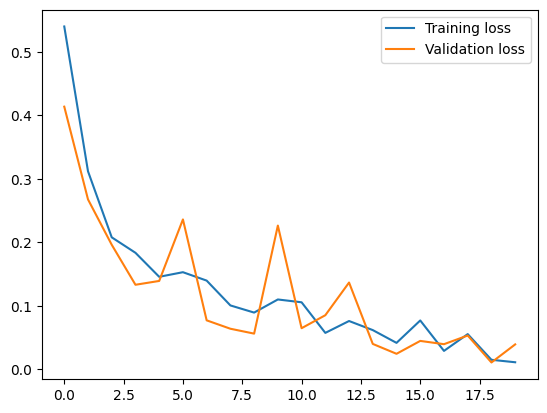

In [ ]:
# plotting the loss
plt.plot(history.history['loss'],label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
#plt.title('loss')
plt.legend()
plt.show()

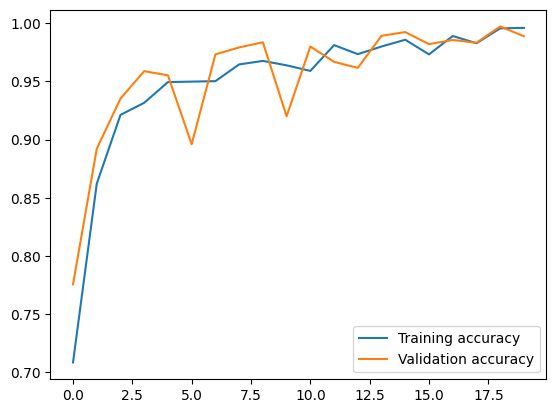

In [ ]:
# Both Validation and Training accuracy is shown here

plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
#plt.title('Accuracy')
plt.legend()
plt.show()

In [ ]:
# CHECKING THE CONFUSION MATRIX

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
Y_pred = model.predict(test_set)
y_pred = np.argmax(Y_pred ,axis =1)


50/50 [==============================] - 14s 250ms/step


In [ ]:
print('Classification Report')
target_names = ['aca','n']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

         aca       0.98      1.00      0.99      1254
           n       1.00      0.98      0.99      1246

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



In [ ]:
loss, acc = model.evaluate_generator(test_set, len(test_set))

print ("\n\n================================\n\n")
print ("Loss: {}".format(loss))
print ("Accuracy: {0:.2f} %".format(acc * 100))
print ("\n\n================================\n\n")

test_set.reset()

<ipython-input-79-9a3d6d22a8aa>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, acc = model.evaluate_generator(test_set, len(test_set))






Loss: 0.040565598756074905
Accuracy: 98.84 %






In [ ]:
result = model.evaluate(test_set,batch_size=128)
print("test_loss, test accuracy",result)

50/50 [==============================] - 13s 250ms/step - loss: 0.0406 - accuracy: 0.9884
test_loss, test accuracy [0.040565598756074905, 0.9883999824523926]


In [ ]:
preds = model.predict(test_set,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

50/50 [==============================] - 13s 255ms/step


In [ ]:
#Confusion Matrix and Classification Report
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Y_pred = model.predict_generator(validation_generator, nb_validation_samples //
#batch_size+1)
y_pred = np.argmax(preds, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))

Confusion Matrix
[[1250    4]
 [  25 1221]]


In [ ]:
print('Classification Report')
target_names = [ 'Colon Benign','Colon Adenocarcinoma']
print(classification_report(test_set.classes, y_pred, target_names=target_names))

Classification Report
                      precision    recall  f1-score   support

        Colon Benign       0.98      1.00      0.99      1254
Colon Adenocarcinoma       1.00      0.98      0.99      1246

            accuracy                           0.99      2500
           macro avg       0.99      0.99      0.99      2500
        weighted avg       0.99      0.99      0.99      2500



In [ ]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

precision_score(test_set.classes, y_pred) , recall_score(test_set.classes, y_pred) ,  f1_score(test_set.classes, y_pred)

(0.996734693877551, 0.9799357945425361, 0.9882638607851073)

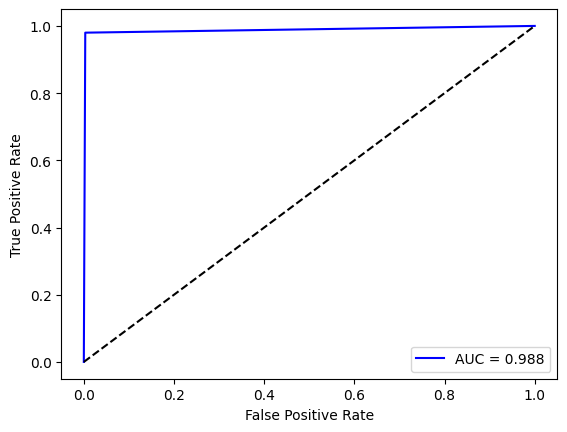

In [ ]:
import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(test_set.classes, y_pred)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
#plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
#plt.title('ROC curve')

plt.show()

<Axes: >

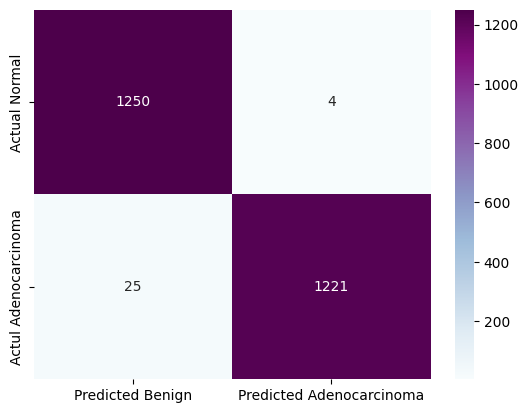

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix( y_true= test_set.classes, y_pred= y_pred, labels=[0, 1]), index=["Actual Normal", "Actul Adenocarcinoma"],columns=["Predicted Benign", "Predicted Adenocarcinoma"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d",cmap="BuPu")

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('my_model.keras')

In [ ]:
pip install tfops
